# Obtaining the eigenstates and eigenenergies via time dependent propagation of the Schrodinger equation

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
from numba import njit
from mub_qhamiltonian import MUBQHamiltonian
from split_op_schrodinger1D import SplitOpSchrodinger1D

In [45]:
# Changing the default size of all the figures 
plt.rcParams['figure.figsize'] = [15, 8]

In [46]:
# parameters of the quantum system to be studied

@njit
def v(x, t=0.):
    """
    Potential energy
    """
    return 0.02 * x ** 4
    
@njit
def k(p, t=0.):
    """
    Non-relativistic kinetic energy
    """
    return 0.5 * p ** 2

quant_sys_params = dict(
    dt = 0.008,
    x_grid_dim=512,
    x_amplitude=10.,
    k=k,
    v=v,
)

In [47]:
# initialize the propagator
quant_sys = SplitOpSchrodinger1D(**quant_sys_params)

# set the initial condition that is not an eigenstate
quant_sys.set_wavefunction(
    lambda x: np.exp(-0.4 * (x + 2.5) ** 2)
)

# Save the evolution
wavefunctions = [quant_sys.propagate().copy() for _ in range(10000)]
wavefunctions = np.array(wavefunctions)

Energy resolution (step size) 0.078540 (a.u.)


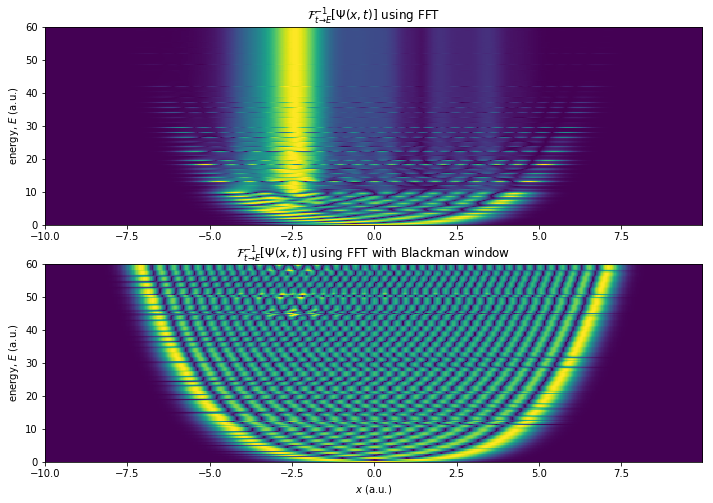

In [48]:
# calculate the alternating sequence of signs for iFFT wavefunction
k = np.arange(wavefunctions.shape[0])
minus = (-1) ** k[:, np.newaxis]

# calculate the inverse Fourier transform with respect to the time axis
wavefunctions_fft = fftpack.ifft(
    minus * wavefunctions,
    axis=0,
    overwrite_x=True
)
wavefunctions_fft *= minus

# energy axis (as prescribed by Method 1 for calculating Fourier transform
energy_range = (k - k.size / 2) * np.pi / (0.5 * quant_sys.dt * k.size)
print("Energy resolution (step size) {:f} (a.u.)".format(energy_range[1] - energy_range[0]))

plt.subplot(211)
plt.title('$\\mathcal{F}_{t \\to E}^{-1}[ \\Psi(x, t) ]$ using FFT')

# post process for better visualization
abs_wavefunctions_fft = np.abs(wavefunctions_fft)
abs_wavefunctions_fft /= abs_wavefunctions_fft.max(axis=1)[:, np.newaxis]


extent = [quant_sys.x[0], quant_sys.x[-1], energy_range[0], energy_range[-1]]

plt.imshow(abs_wavefunctions_fft, extent=extent, origin='lower', aspect=0.1)
plt.ylabel('energy, $E$ (a.u.)')
plt.ylim(0., 60.)

#############################################################################

plt.subplot(212)
plt.title('$\\mathcal{F}_{t \\to E}^{-1}[ \\Psi(x, t) ]$ using FFT with Blackman window')

# the windowed fft of the evolution
# to remove the spectral leaking. For details see
# rhttp://docs.scipy.org/doc/scipy/reference/tutorial/fftpack.html
from scipy.signal import blackman

wavefunctions_fft_w = fftpack.ifft(
    minus * wavefunctions * blackman(k.size)[:, np.newaxis],
    axis=0,
    overwrite_x=True
)
wavefunctions_fft_w *= minus

# post process for better visualization
abs_wavefunctions_fft_w = np.abs(wavefunctions_fft_w)
abs_wavefunctions_fft_w /= abs_wavefunctions_fft_w.max(axis=1)[:, np.newaxis]

plt.imshow(abs_wavefunctions_fft_w, extent=extent, origin='lower', aspect=0.1)
plt.xlabel('$x$ (a.u.)')
plt.ylabel('energy, $E$ (a.u.)')
plt.ylim(0., 60.)
plt.show()

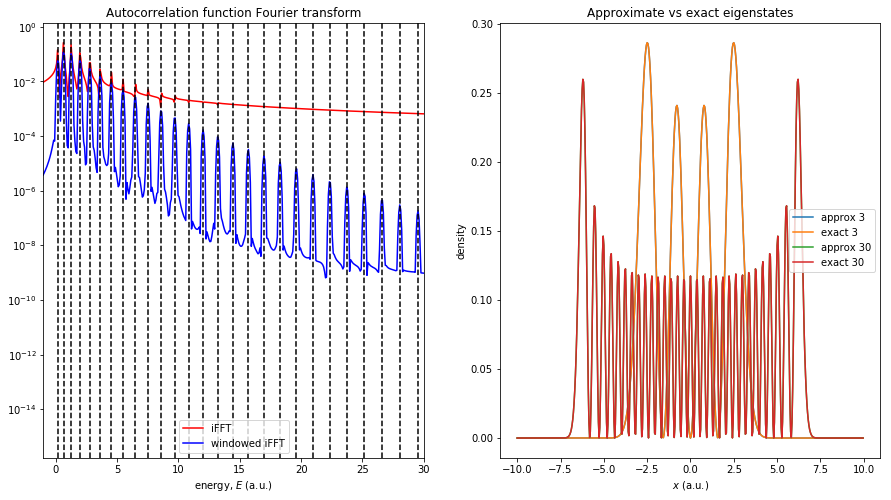

In [49]:
# Find eigenvalues and eigenfunctions by diagonalizing the MUB hamiltonian
exact = MUBQHamiltonian(**quant_sys_params).diagonalize()

# calculate the auto correlation function
auto_corr = np.array(
    [np.vdot(wavefunctions[0], psi) * quant_sys.dx for psi in wavefunctions]
)

# calculate the alternating sequence of signs for iFFT autocorrelation function
minus = (-1) ** k

# abs(fft) of the auto correlation function
auto_corr_fft = np.abs(
    fftpack.ifft(minus * auto_corr, overwrite_x=True)
)

#plt.subplot(221)
# the windowed fft of the auto correlation function
auto_corr_fft_w = np.abs(
    fftpack.ifft(minus * auto_corr * blackman(auto_corr.size), overwrite_x=True)
)

plt.subplot(121)
plt.title("Autocorrelation function Fourier transform")
plt.semilogy(energy_range, auto_corr_fft, 'r', label='iFFT')
plt.semilogy(energy_range, auto_corr_fft_w, 'b', label='windowed iFFT')

# draw vertical lines depicting the exact energies
for ee in exact.energies:
    plt.axvline(ee, linestyle='--', color='black')

plt.xlim([-1., 30.])
plt.legend(loc='lower center')
plt.xlabel('energy, $E$ (a.u.)')

#############################################################################

plt.subplot(122)
plt.title("Approximate vs exact eigenstates")

# loop over the indices (i.e., principle quantum numbers) of the eigenstates to be compared
for indx in [3, 30]:

    # extract approximate eigenstate from wavefunctions_fft_w
    density = wavefunctions_fft_w[
        np.searchsorted(energy_range, exact.energies[indx])
    ]

    # normalize the underlying density
    density = np.abs(density) ** 2
    density /= density.sum() * quant_sys.dx
    plt.plot(quant_sys.x, density, label="approx {}".format(indx))

    # plot the exact eigenstate
    plt.plot(quant_sys.x, np.abs(exact.eigenstates[indx])**2, label='exact {}'.format(indx))

plt.legend()
plt.xlabel('$x$ (a.u.)')
plt.ylabel('density')

plt.show()